# Imports 

In [2]:
import requests
import json
import re
from nltk.tokenize import wordpunct_tokenize
import nltk
from nltk.stem.isri import ISRIStemmer
import pandas as pd 
import random
import pyarabic.trans
from nltk.tokenize import wordpunct_tokenize
import nltk
import torch.optim as optim

# Part1 Classification Regression:

## Scraping :  
*chosen Topic* : Court judjment on israel

In [3]:
df = pd.read_json("output.json")

In [4]:
df.head()

,url,text
0,https://www.aljazeera.net/politics,ضمن فصول جديدة من صراع القوى العالمية على القا...
1,https://www.aljazeera.net/health/,كشفت دراسة أميركية أن تناول الكثير من الأطعمة ...
2,https://www.aljazeera.net/opinion/,أمام غطرسة السلطة الرئاسية وتماديها في تهديد ا...
3,https://www.aljazeera.net/where/europe/ukraine/,نقلت وكالة رويترز عن مصادر روسية أن الرئيس فلا...
4,https://www.aljazeera.net/africa-2,يتناول التحقيق كيف يدعم ويمول الاتحاد الأوروبي...


In [5]:
df.drop_duplicates(inplace=True)
df.drop(columns=["url"] , inplace=True)

In [6]:

def calculate_relevance(tokens):
    # Define relevant keywords
    relevant_keywords = [
    'محكمة', 'إسرائيل', 'انتهاك', 'قرار', 'دولي', 'حكم', 'قانون', 'قضائي', 'دعوى', 
    'قضية', 'محاكمة', 'عدالة', 'إدانة', 'قانوني', 'احتلال', 'الشرعية', 
    'الإجراءات', 'حقوق الإنسان', 'الاتهام', 'العقوبة', 'الاستئناف', 'الجلسة',  'الإسرائيلي', 'القضائية', 'السيادة', 'التحكيم', 'المحامين', 'العدالة'
    ]
    score = 1
    if 'إسرائيل' or 'الإسرائيلي' in tokens:
        for token in tokens:
            if token in relevant_keywords:
                score += 1
    return score

def rate_text(text):
    tokens= wordpunct_tokenize(text)
    relevance_score = calculate_relevance(tokens)
    return min(10, relevance_score)

# Apply the rating function to the DataFrame
df['score'] = df['text'].apply(rate_text)

### Load data 

In [7]:
df = pd.read_csv("data.csv")

In [8]:
df.head()

,Unnamed: 0,text,score
0,0,ضمن فصول جديدة من صراع القوى العالمية على القا...,10
1,1,كشفت دراسة أميركية أن تناول الكثير من الأطعمة ...,1
2,2,أمام غطرسة السلطة الرئاسية وتماديها في تهديد ا...,1
3,3,نقلت وكالة رويترز عن مصادر روسية أن الرئيس فلا...,2
4,4,يتناول التحقيق كيف يدعم ويمول الاتحاد الأوروبي...,3


In [9]:
def clean_arabic_text(text):
    text = str(text)
    #Remove \n
    text=re.sub(r'\n', '', text)
    # Remove links
    text = re.sub(r'http\S+', '', text)
    # Remove emails
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    
    # Remove phone numbers
    text = re.sub(r'\b(?:0|\+?44)[\d\s-]{9,13}\b', '', text)
    
    # Remove any remaining non-word characters
    text = re.sub(r'[^\w\s]', '', text)
    # Segment the text into Arabic and non-Arabic parts
    segmented_text = pyarabic.trans.segment_language(text)
    
    # Concatenate only the Arabic parts
    arabic_text = ''.join([segment[1] for segment in segmented_text if segment[0] == 'arabic'])
    
    # Remove extra spaces
    arabic_text = re.sub(r'\s+', ' ', arabic_text)
    
    return arabic_text.strip()

In [10]:
def tokenize(text):
    return wordpunct_tokenize(text)

In [11]:
def del_stop_words(tokens):
    arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))
    filtered_tokens = [token for token in tokens if token not in arb_stopwords]
    return filtered_tokens


In [12]:
def stem(tokens):
    st = ISRIStemmer()
    stemmed_tokens = []
    for token in tokens:
        stemmed_token = st.stem(token)
        stemmed_tokens.append(stemmed_token)
    return stemmed_tokens

In [13]:
def pipeline(df): 
    df["text"] = df["text"].apply(clean_arabic_text)
    df["text_tokenized"] = df["text"].apply(tokenize)
    df["text_tokenized"] = df["text_tokenized"].apply(del_stop_words) 
    df["text_stem"] = df["text_tokenized"].apply(stem)
    return df
    


In [14]:
df = pipeline(df)

In [15]:
df.head()

,Unnamed: 0,text,score,text_tokenized,text_stem
0,0,ضمن فصول جديدة من صراع القوى العالمية على القا...,10,"[ضمن, فصول, جديدة, صراع, القوى, العالمية, القا...","[ضمن, فصل, جدد, صرع, قوى, علم, قرة, راء, برز, ..."
1,1,كشفت دراسة أميركية أن تناول الكثير من الأطعمة ...,1,"[كشفت, دراسة, أميركية, تناول, الكثير, الأطعمة,...","[كشف, درس, امر, نول, كثر, طعم, علج, رقق, بطط, ..."
2,2,أمام غطرسة السلطة الرئاسية وتماديها في تهديد ا...,1,"[غطرسة, السلطة, الرئاسية, وتماديها, تهديد, الم...","[غطرس, سلط, رئس, تمد, هدد, سار, ديمقراطي, وصل,..."
3,3,نقلت وكالة رويترز عن مصادر روسية أن الرئيس فلا...,2,"[نقلت, وكالة, رويترز, مصادر, روسية, الرئيس, فل...","[نقل, وكل, رويترز, صدر, روس, رئس, فلاديمير, بو..."
4,4,يتناول التحقيق كيف يدعم ويمول الاتحاد الأوروبي...,3,"[يتناول, التحقيق, يدعم, ويمول, الاتحاد, الأورو...","[نول, حقق, دعم, يمل, تحد, ورب, بعض, دول, عمل, ..."


In [16]:
import pandas as pd
import torch
from collections import defaultdict
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

/home/unamed/.conda/envs/myenv/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/unamed/.conda/envs/myenv/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [17]:
# Build the vocabulary
vocab = build_vocab_from_iterator(df["text_stem"], specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Tokenize and build the vocabulary
tokenized_X = []
for sentence in df["text_stem"]:
    indices = [vocab[word] for word in sentence]
    tokenized_X.append(indices)

# Convert the tokenized sentences to tensors and pad them
X_tensors = [torch.tensor(sentence, dtype=torch.long) for sentence in tokenized_X]
X_padded = pad_sequence(X_tensors, batch_first=True, padding_value=0)

# Convert y to tensor
y_tensor = torch.tensor(df['score'].values.tolist(), dtype=torch.float32).view(-1, 1)


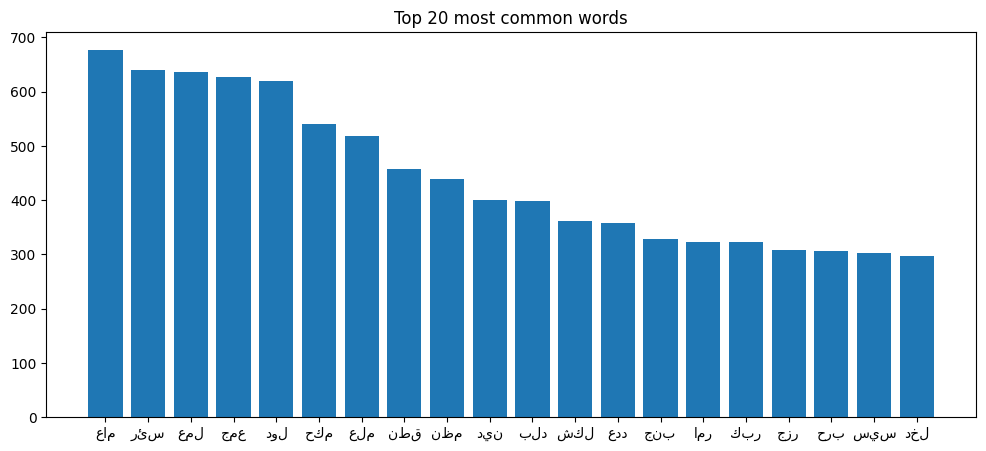

[[243, 140, 83, 349, 789, 7, 291, 2032, 244, 375, 19, 2497, 639, 126, 51, 45, 153, 42, 284, 2238, 978, 176, 212, 107, 1863, 2, 2, 47, 2239, 48, 52, 197, 712, 4271, 164, 514, 3357, 95, 154, 937, 729, 2864, 349, 2240, 428, 604, 729, 134, 604, 587, 515, 37, 244, 9, 105, 552, 1606, 92, 938, 939, 285, 180, 42, 6, 79, 5, 730, 119, 890, 75, 141, 75, 731, 1126, 2241, 77, 299, 223, 358, 184, 2498, 177, 71, 401, 24, 63, 2499, 63, 170, 2865, 349, 299, 539, 732, 1206, 1607, 27, 15, 3358, 760, 278, 2866, 1719, 6, 3359, 564, 850, 34, 2867, 5, 790, 418, 2500, 2868, 270, 1720, 73, 791, 72, 65, 141, 85, 1608, 6, 236, 16, 165, 9, 105, 1070, 6, 376, 713, 231, 2869, 92, 143, 239, 92, 18, 226, 821, 2033, 76, 181, 105, 1, 618, 666, 473, 114, 402, 49, 3360, 3361, 1127, 55, 383, 312, 730, 279, 159, 143, 77, 144, 851, 1071, 1283, 5, 1428, 14, 95, 761, 143, 73, 27, 212, 48, 2242, 474, 74, 640, 2870, 304, 463, 286, 98, 114, 66, 2243, 940, 377, 11, 229, 2244, 5, 39, 40, 160, 160, 5, 390, 1348, 39, 8, 179, 1027, 3

In [18]:
import re
import string
from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Tokenize - Create Vocab to Int
corpus = [word for sublist in df['text_stem'] for word in sublist]
count_words = Counter(corpus)
sorted_words = count_words.most_common()

# Plot top 20 most common words (optional)
import matplotlib.pyplot as plt
keys, values = zip(*sorted_words[:20])
plt.figure(figsize=(12, 5))
plt.bar(keys, values)
plt.title('Top 20 most common words')
plt.show()

# Create vocabulary to integer mapping
vocab_to_int = {w: i + 1 for i, (w, c) in enumerate(sorted_words)}

# Tokenize - Encode the text
text_int = []
for text in df['text_stem']:
    r = [vocab_to_int[word] for word in text]
    text_int.append(r)
print(text_int[:1])
df['text_done'] = text_int

# Padding/Truncating the data
def padding(text_int, seq_len):
    features = np.zeros((len(text_int), seq_len), dtype=int)
    for i, text in enumerate(text_int):
        if len(text) <= seq_len:
            zeros = list(np.zeros(seq_len - len(text)))
            new = zeros + text
        else:
            new = text[:seq_len]
        features[i, :] = np.array(new)
    return features

# Assuming your sequence length is 200
features = padding(text_int, 200)
print(features[0, :])

# Train-validation-test split
X_train, X_remain, y_train, y_remain = train_test_split(features, df['score'].to_numpy(), test_size=0.2, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=1)

# Now you have your preprocessed dataset split into training, validation, and test sets.
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
# dataloaders
batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)


## LSTM

In [30]:
class LSTM_RNN(nn.Module):
    
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0):
        super(LSTM_RNN, self).__init__()
        """
            Initialize the model by setting up the layers.
        """
        super().__init__()
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob,
        batch_first=True)
        # Dropout layer
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
# Linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        #self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        #embedding and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        #stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        # Dropout and fully connected layer
        out = self.dropout(lstm_out)
        out  = self.relu(out)
        out = self.fc(out)
        #sigmoid function
        """
        sig_out = self.sigmoid(out)
        # reshape to be batch size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels"""
        return out.view(batch_size, -1)[:, -1], hidden
    def init_hidden(self, batch_size):
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim))
        c0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim))
        hidden = (h0,c0)
        return hidden


## RNN

In [24]:
class RNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.0):
        super(RNN, self).__init__()
        """
        Initialize the model by setting up the layers.
        """
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Embedding and RNN layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, nonlinearity='tanh', bias=True, batch_first=True, dropout=drop_prob, bidirectional=False)
        
        # Dropout layer
        self.dropout = nn.Dropout(drop_prob)
        self.relu = nn.ReLU()
        
        # Linear layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        
        # Embedding and RNN
        embeds = self.embedding(x)
        rnn_out, hidden = self.rnn(embeds, hidden)
        
        # Stack up RNN outputs
        rnn_out = rnn_out.contiguous().view(-1, self.hidden_dim)
        
        # Dropout and fully connected layer
        out = self.dropout(rnn_out)
        out = self.relu(out)
        out = self.fc(out)
        
        # Reshape to be batch size first
        out = out.view(batch_size, -1)[:, -1]
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        """
        Initialize hidden state.
        """
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden



## Bidirectional RNN

In [35]:
class Bi_RNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.0):
        super(Bi_RNN, self).__init__()
        """
        Initialize the model by setting up the layers.
        """
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Embedding and RNN layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, nonlinearity='tanh', bias=True, dropout=drop_prob, bidirectional=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(drop_prob)
        self.relu = nn.ReLU()
        
        # Linear layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        
        # Embedding and RNN
        embeds = self.embedding(x)
        rnn_out, hidden = self.rnn(embeds, hidden)
        
        # Stack up RNN outputs
        rnn_out = rnn_out.contiguous().view(-1, self.hidden_dim)
        
        # Dropout and fully connected layer
        out = self.dropout(rnn_out)
        out = self.relu(out)
        out = self.fc(out)
        
        # Reshape to be batch size first
        out = out.view(batch_size, -1)[:, -1]
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        """
        Initialize hidden state.
        """
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden



### training

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_rnn_model(rnn,vocab_to_int, train_loader, epochs=10, batch_size=50, lr=0.001 ):
    # Instantiate the model with hyperparameters
    vocab_size = len(vocab_to_int) + 1
    output_size = 1
    print(rnn)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(rnn.parameters(), lr=lr)

    for epoch in range(epochs):  # Loop over the dataset multiple times
        h = rnn.init_hidden(batch_size)  # Initialize hidden state
        rnn.train()
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            labels = labels.float()

            # Ensure the hidden state is correctly managed
            if isinstance(h, tuple):
                h = tuple([each.data for each in h])
            else:
                h = h.data

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs, h = rnn(inputs, h)
            loss = criterion(outputs, labels)
            print("Current loss:", loss)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # Print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')
    return rnn, optimizer

# Example usage:
# Assuming vocab_to_int is defined and train_loader is your DataLoader
# 


In [32]:
vocab_size = len(vocab_to_int) +1
lstm = LSTM_RNN(vocab_size, output_size= 1, embedding_dim=220, hidden_dim=300, n_layers=3)
lstm, optimizer = train_rnn_model(lstm,vocab_to_int=vocab_to_int, train_loader=train_loader)

LSTM_RNN(
  (embedding): Embedding(7162, 220)
  (lstm): LSTM(220, 300, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (fc): Linear(in_features=300, out_features=1, bias=True)
)


/home/unamed/.conda/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current loss: tensor(13.2547, grad_fn=<MseLossBackward0>)
Current loss: tensor(12.9778, grad_fn=<MseLossBackward0>)
Current loss: tensor(13.2785, grad_fn=<MseLossBackward0>)
Current loss: tensor(15.7135, grad_fn=<MseLossBackward0>)
Current loss: tensor(5.7622, grad_fn=<MseLossBackward0>)
Current loss: tensor(8.7126, grad_fn=<MseLossBackward0>)
Current loss: tensor(8.8047, grad_fn=<MseLossBackward0>)
Current loss: tensor(5.2756, grad_fn=<MseLossBackward0>)
Current loss: tensor(7.9601, grad_fn=<MseLossBackward0>)
Current loss: tensor(10.0714, grad_fn=<MseLossBackward0>)
Current loss: tensor(6.4490, grad_fn=<MseLossBackward0>)
Current loss: tensor(4.1686, grad_fn=<MseLossBackward0>)
Current loss: tensor(5.1051, grad_fn=<MseLossBackward0>)
Current loss: tensor(8.5681, grad_fn=<MseLossBackward0>)
Current loss: tensor(5.6580, grad_fn=<MseLossBackward0>)
Current loss: tensor(3.9880, grad_fn=<MseLossBackward0>)
Current loss: tensor(9.6585, grad_fn=<MseLossBackward0>)
Current loss: tensor(6.590

In [33]:
rnn = RNN(vocab_size, output_size= 1, embedding_dim=220, hidden_dim=300, n_layers=3)
rnn, optimizer = train_rnn_model(rnn,vocab_to_int=vocab_to_int, train_loader=train_loader)

RNN(
  (embedding): Embedding(7162, 220)
  (rnn): RNN(220, 300, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (relu): ReLU()
  (fc): Linear(in_features=300, out_features=1, bias=True)
)
Current loss: tensor(15.6228, grad_fn=<MseLossBackward0>)
Current loss: tensor(11.6631, grad_fn=<MseLossBackward0>)
Current loss: tensor(9.0929, grad_fn=<MseLossBackward0>)
Current loss: tensor(7.3981, grad_fn=<MseLossBackward0>)
Current loss: tensor(4.7010, grad_fn=<MseLossBackward0>)
Current loss: tensor(3.7581, grad_fn=<MseLossBackward0>)
Current loss: tensor(5.4899, grad_fn=<MseLossBackward0>)
Current loss: tensor(5.8573, grad_fn=<MseLossBackward0>)
Current loss: tensor(5.1484, grad_fn=<MseLossBackward0>)
Current loss: tensor(5.4037, grad_fn=<MseLossBackward0>)
Current loss: tensor(6.7296, grad_fn=<MseLossBackward0>)
Current loss: tensor(5.7475, grad_fn=<MseLossBackward0>)
Current loss: tensor(6.7769, grad_fn=<MseLossBackward0>)
Current loss: tensor(2.5806, grad_fn=<Ms

In [ ]:
bi_rnn = Bi_RNN(vocab_size, output_size= 1, embedding_dim=220, hidden_dim=300, n_layers=3).cuda()
bi_rnn, optimizer = train_rnn_model(bi_rnn,vocab_to_int=vocab_to_int, train_loader=train_loader)

In [84]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error

def predict(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_losses = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            labels = labels.float()
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size)

            # Ensure the hidden state is correctly managed
            if isinstance(h, tuple):
                h = tuple([each.data for each in h])
            else:
                h = h.data

            outputs, h = model(inputs, h)
            loss = criterion(outputs.squeeze(), labels)
            test_losses.append(loss.item())

            # Collect predictions and labels without rounding
            preds = torch.round(outputs.squeeze()).tolist()
            all_preds.extend(preds)
            all_labels.extend(labels.tolist())

    avg_test_loss = sum(test_losses) / len(test_losses)
    mse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)

    print(f'Test Loss: {avg_test_loss:.3f}')
    print(f'Mean Squared Error (MSE): {mse:.3f}')
    print(f'Mean Absolute Error (MAE): {mae:.3f}')
    
    return all_preds, all_labels

# Example usage:
# Assuming rnn is your model, test_loader is your DataLoader, and criterion is your loss function
test_preds, test_labels = predict(rnn, test_loader, criterion)
print("Test Predictions:", test_preds)
print("Test Labels:", test_labels)


Test Loss: 9.652
Mean Squared Error (MSE): 9.417
Mean Absolute Error (MAE): 1.833
Test Predictions: [1.0, 3.0, 3.0, 1.0, 1.0, 2.0, 2.0, 4.0, 1.0, 2.0, 2.0, 2.0, 3.0, 1.0, 5.0, 4.0, 3.0, 1.0, 1.0, 3.0, 2.0, 1.0, 1.0, 2.0]
Test Labels: [1.0, 10.0, 1.0, 1.0, 4.0, 3.0, 2.0, 10.0, 1.0, 2.0, 2.0, 1.0, 5.0, 10.0, 6.0, 1.0, 1.0, 1.0, 1.0, 2.0, 7.0, 1.0, 1.0, 1.0]


###  RNN